In [1]:
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt

directory = 'voterdata'
# demographic_name = 'VM2--MA--2022-12-31-DEMOGRAPHIC.tab'
# vote_history_name = 'VM2--MA--2022-12-31-VOTEHISTORY.tab'
voter_name = 'VM2Uniform--MA--2022-08-19.tab' # the uniform file combines both





What is the voting profile for (census tracts or ward/precincts) where there is a high ratio of approved permits or zoning board of appeal decisions: Voter file for Boston (pull from MA)


In [3]:
# for now, we'll load the first 10k rows; eventually, use chunks to process the entire file
voter_data = pd.read_csv(directory + '/' + voter_name, sep='\t', nrows=10000)

voter_data.head()

C:\Users\Andre\AppData\Local\Temp\ipykernel_26876\259193643.py:2: DtypeWarning: Columns (19,26,27,30,50,57,58,61,117,126,189,304,325,393,406,408,409,451,454,465,697) have mixed types. Specify dtype option on import or set low_memory=False.
  voter_data = pd.read_csv(directory + '/' + voter_name, sep='\t', nrows=10000)


,SEQUENCE,LALVOTERID,Voters_Active,Voters_StateVoterID,Voters_CountyVoterID,VoterTelephones_LandlineAreaCode,VoterTelephones_Landline7Digit,VoterTelephones_LandlineFormatted,VoterTelephones_LandlineUnformatted,VoterTelephones_LandlineConfidenceCode,...,PRI_BLT_2009,PRI_BLT_2008,PRI_BLT_2007,PRI_BLT_2006,PRI_BLT_2005,PRI_BLT_2004,PRI_BLT_2003,PRI_BLT_2002,PRI_BLT_2001,PRI_BLT_2000
0,1,LALMA528324496,I,02FLS1497000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,LALMA518128944,I,07LME0362003,NaN,508.0,771-4848,(508) 771-4848,5.087715e+09,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,LALMA162304139,I,05WHY0374001,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,LALMA160666743,I,09BTY0175001,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,LALMA549110882,I,03SKE0954001,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# export to csv for easier visualization
voter_data.to_csv('voter_data_10k.csv')

In [5]:
# export columns to txt file for easier reference
with open('voter_data_columns.txt', 'w') as f:
    for col in voter_data.columns:
        f.write(col + '\n')

Preliminary notes on what columns might be useful or can be safely discarded

Useful:
- voter status (active/inactive)
- residence details (house/apt, sq ft, etc)
- state moved from
- 

Not useful:
- Telephones
- Name

Unsure:
- Should we only consider ZIPs surrounding Boston?
- Should we look at the older datasets or just 2022-12?



In [6]:
# Data needs to be verified
# Source: https://www.cityofboston.gov/images_documents/ZipCodes_tcm3-47884.pdf
# Dictionary for Boston Neighborhoods
boston_neighborhoods = {
    '02116': 'Back Bay',
    '02199': 'Back Bay',
    '02108': 'Beacon Hill',
    '02114': 'Beacon Hill',
    '02129': 'Charlestown',
    '02121': 'Dorchester',
    '02122': 'Dorchester',
    '02125': 'Dorchester',
    '02124': 'Dorchester',
    '02128': 'East Boston',
    '02115': 'Fenway/Kenmore',
    '02215': 'Fenway/Kenmore',
    '02136': 'Hyde Park',
    '02130': 'Jamaica Plain',
    '02126': 'Mattapan',
    '02109': 'North End',
    '02113': 'North End',
    '02131': 'Roslindale',
    '02119': 'Roxbury',
    '02120': 'Roxbury',
    '02127': 'South Boston',
    '02118': 'South End',
    '02132': 'West Roxbury',
}

surrounding_areas = {
    '02445': 'Brookline',
    '02446': 'Brookline',
    '02138': 'Cambridge',
    '02139': 'Cambridge',
    '02140': 'Cambridge',
    '02141': 'Cambridge',
    '02142': 'Cambridge',
    '02150': 'Chelsea',
    '02458': 'Newton',
    '02459': 'Newton',
    '02460': 'Newton',
    '02461': 'Newton',
    '02462': 'Newton',
    '02464': 'Newton',
    '02465': 'Newton',
    '02466': 'Newton',
    '02467': 'Newton',
    '02468': 'Newton',
    '02169': 'Quincy',
    '02170': 'Quincy',
    '02171': 'Quincy',
    '02269': 'Quincy',
    '02143': 'Somerville',
    '02144': 'Somerville',
    '02145': 'Somerville',
    '02149': 'Everett',
    '02151': 'Revere',
    '02472': 'Watertown',
    '02478': 'Belmont',
    '02026': 'Dedham',
    '02186': 'Milton',
}

# drop leading 0 from zip codes in dict, since that's how they're stored

boston_neighborhoods = {k.lstrip('0'): v for k, v in boston_neighborhoods.items()}
surrounding_areas = {k.lstrip('0'): v for k, v in surrounding_areas.items()}

print(boston_neighborhoods)

{'2116': 'Back Bay', '2199': 'Back Bay', '2108': 'Beacon Hill', '2114': 'Beacon Hill', '2129': 'Charlestown', '2121': 'Dorchester', '2122': 'Dorchester', '2125': 'Dorchester', '2124': 'Dorchester', '2128': 'East Boston', '2115': 'Fenway/Kenmore', '2215': 'Fenway/Kenmore', '2136': 'Hyde Park', '2130': 'Jamaica Plain', '2126': 'Mattapan', '2109': 'North End', '2113': 'North End', '2131': 'Roslindale', '2119': 'Roxbury', '2120': 'Roxbury', '2127': 'South Boston', '2118': 'South End', '2132': 'West Roxbury'}


In [11]:
# get all columns containing 'zip'

zip_columns = [col for col in voter_data.columns if 'zip' in col.lower()]
print(zip_columns)

# for each zip column, print first 30 values
for col in zip_columns:
    print(col)
    print(voter_data[col].value_counts().head(30))
    print('\n')

print(voter_data['Community_Service_District'].value_counts().head(30))


['Residence_Addresses_Zip', 'Residence_Addresses_ZipPlus4', 'Mailing_Addresses_Zip', 'Mailing_Addresses_ZipPlus4']
Residence_Addresses_Zip
Residence_Addresses_Zip
2632    3769
2601    3206
2630    2656
2668     174
2675      31
2537      20
2563      14
2660      13
2645      13
2540      10
2673      10
2664       9
2536       9
2638       9
2559       8
2649       8
2653       6
2655       6
2633       6
2639       5
2646       4
2631       3
2532       2
2644       2
2671       2
2635       2
2647       2
2648       1
Name: count, dtype: int64


Residence_Addresses_ZipPlus4
Residence_Addresses_ZipPlus4
3637.0    48
2453.0    37
2451.0    32
2300.0    31
3673.0    30
1614.0    30
2449.0    30
3666.0    29
6211.0    29
2472.0    28
2415.0    28
3621.0    28
3246.0    28
2473.0    28
1608.0    28
1626.0    27
2417.0    27
2312.0    27
1542.0    27
2409.0    27
1634.0    26
1615.0    26
3536.0    26
1810.0    26
1416.0    26
2304.0    26
2448.0    26
2455.0    25
2462.0    25
2532.0    

In [ ]:

# go through the full dataset and clean up any columns that don't have much data
# also grab zip codes and cities to determine format

chunk_size = 50000
col_counts = {}  # Dictionary to store the non-null count for each column's data
path = 'voterdata/VM2Uniform--MA--2022-08-19.tab'

ma_cities = {} # zipcode: city
# First pass: Count non-null rows in each column
for chunk in pd.read_csv(path, chunksize=chunk_size, sep='\t', encoding_errors='replace', encoding='ascii'):
    for col in chunk.columns:
        if col not in col_counts:
            col_counts[col] = 0
        col_counts[col] += chunk[col].count()
    zip_pair = chunk[['Residence_Addresses_Zip', 'Residence_Addresses_City']].drop_duplicates()
    temp_dict = dict(zip_pair.values)
    ma_cities.update(temp_dict)
    


threshold = 0.3 * chunk_size 

# Identify columns to keep based on the threshold
cols_to_keep = [col for col, count in col_counts.items() if count >= threshold]

print(cols_to_keep)





In [29]:
# save ma_cities to txt
with open('ma_cities.txt', 'w') as f:
    for k, v in ma_cities.items():
        f.write(str(k) + ': ' + v + '\n')

In [17]:
# filter out non-boston zip codes, save to CSV

boston_zip_codes = [
    "02134", "02125", "02110", "02118", "02126", "02109", "02113", "02130",
    "02121", "02119", "02115", "02163", "02135", "02199", "02124", "02132",
    "02114", "02108", "02136", "02111", "02210", "02116", "02131", "02127",
    "02120", "02203", "02215", "02129", "02128", "02122", "02151", "02467",
]
boston_zip_codes_int = [int(x) for x in boston_zip_codes] # zip codes stored as ints in csv
path = 'voterdata/VM2Uniform--MA--2022-08-19.tab'

writeHeader = True

for chunk in pd.read_csv(path, chunksize=50000, sep='\t', encoding_errors='replace', encoding='ascii'):
    chunk = chunk[chunk['Residence_Addresses_Zip'].isin(boston_zip_codes_int)]
    
    chunk.to_csv('voterdata/boston_voter_data.csv', mode='a', header=writeHeader, index=False)
    writeHeader = False


C:\Users\Andre\AppData\Local\Temp\ipykernel_33372\3073272488.py:12: DtypeWarning: Columns (19,26,27,30,31,50,57,58,61,78,113,117,126,189,304,325,393,400,404,406,408,409,421,422,445,446,451,454,465,468,697) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(path, chunksize=100000, sep='\t', encoding_errors='replace', encoding='ascii'):
C:\Users\Andre\AppData\Local\Temp\ipykernel_33372\3073272488.py:12: DtypeWarning: Columns (19,26,27,30,31,32,50,57,58,61,62,74,78,87,88,89,90,91,92,93,113,115,126,189,304,325,392,393,400,404,406,408,409,421,422,446,451,454,465,468,479) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(path, chunksize=100000, sep='\t', encoding_errors='replace', encoding='ascii'):
C:\Users\Andre\AppData\Local\Temp\ipykernel_33372\3073272488.py:12: DtypeWarning: Columns (19,26,27,30,31,32,50,57,58,61,62,63,78,113,115,117,126,189,304,325,392,393,404,406,408,409,421,422,446,45

In [ ]:

# Second pass: Read file again and keep only necessary columns
filtered_chunks = []  # List to store filtered chunks
for chunk in pd.read_csv(path, usecols=cols_to_keep, chunksize=chunk_size, sep='\t'):
    filtered_chunks.append(chunk)

# Combine filtered chunks back into a single DataFrame
filtered_df = pd.concat(filtered_chunks, axis=0)

# Save filtered data to new file
filtered_df.to_csv("filtered_voter_data.csv", index=False)


In [26]:
print('col_count:', len(col_counts))
print('cols_to_keep:', len(cols_to_keep))

"""
col_count: 771
cols_to_keep: 509, threshold = 0.3
"""

col_count: 771
cols_to_keep: 509


In [13]:
col = ['CommercialData_EstimatedHHIncome',
'CommercialData_EstimatedHHIncomeAmount',
'CommercialData_EstimatedAreaMedianHHIncome']

cols = col+zip_columns+['Ethnic_Description']

full_data = pd.read_csv(directory + '/' + voter_name,   sep='\t', usecols=cols)

,CommercialData_EstimatedHHIncome,CommercialData_EstimatedHHIncomeAmount,CommercialData_EstimatedAreaMedianHHIncome,Residence_Addresses_Zip,Residence_Addresses_ZipPlus4,Mailing_Addresses_Zip,Mailing_Addresses_ZipPlus4,Ethnic_Description
0,$75000-99999,$76957,$76957,2638,2550.0,2638.0,2550.0,NaN
1,NaN,NaN,NaN,2673,2556.0,2673.0,2556.0,Irish
2,$75000-99999,$83487,$83487,2536,6206.0,2536.0,6206.0,Dutch (Netherlands)
3,$75000-99999,$83487,$83487,2536,6206.0,2536.0,6206.0,English/Welsh
4,$250000+,$250000,NaN,2559,NaN,2559.0,NaN,English/Welsh
5,$75000-99999,$93268,$93268,2639,1008.0,2662.0,890.0,Italian
6,NaN,NaN,NaN,2660,NaN,2660.0,NaN,Irish
7,NaN,NaN,NaN,2660,NaN,2660.0,NaN,Irish
8,$50000-74999,$71070,$71070,2540,2804.0,2540.0,2804.0,NaN
9,$50000-74999,$73199,$73199,2660,2531.0,2660.0,2531.0,English/Welsh


In [2]:
boston_data = pd.read_csv('voterdata/boston_voter_data.csv')

C:\Users\Andre\AppData\Local\Temp\ipykernel_16204\4192476491.py:1: DtypeWarning: Columns (19,26,27,30,31,50,57,58,61,62,74,78,87,88,89,90,91,92,93,113,114,115,117,392,393,396,397,398,400,401,402,403,404,405,406,408,409,411,412,414,421,422,423,433,438,441,444,445,446,447,448,451,453,454,457,458,459,463,465,468,473,474,479,481,697,702,706,711,715,720,729,733,738,742,746,747) have mixed types. Specify dtype option on import or set low_memory=False.
  boston_data = pd.read_csv('voterdata/boston_voter_data.csv')


In [3]:
boston_data.head(50)

,SEQUENCE,LALVOTERID,Voters_Active,Voters_StateVoterID,Voters_CountyVoterID,VoterTelephones_LandlineAreaCode,VoterTelephones_Landline7Digit,VoterTelephones_LandlineFormatted,VoterTelephones_LandlineUnformatted,VoterTelephones_LandlineConfidenceCode,...,PRI_BLT_2009,PRI_BLT_2008,PRI_BLT_2007,PRI_BLT_2006,PRI_BLT_2005,PRI_BLT_2004,PRI_BLT_2003,PRI_BLT_2002,PRI_BLT_2001,PRI_BLT_2000
0,1670221,LALMA162475255,I,07SEF2378002,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1670336,LALMA410235215,I,04SEH3082001,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1670337,LALMA518150205,I,04SAY0396001,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1670338,LALMA552705926,I,08MTR0500001,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1670339,LALMA159993816,I,09MMY0565003,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1670340,LALMA493756281,I,09MJN0897004,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1670341,LALMA160058130,I,01MSN1665002,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1670342,LALMA161805090,I,03RLA2742001,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,D,NaN,D,NaN,NaN,NaN,D,NaN,NaN
8,1670401,LALMA552632310,I,04VHN0584000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1670872,LALMA581243124,I,04MTS0699000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
interest_cols = [col for col in boston_data.columns if 'commercialdata' in col.lower()]
residence_cols = [col for col in boston_data.columns if 'residence_' in col.lower()]
voters_cols = [col for col in boston_data.columns if 'voters_' in col.lower()]
income_cols = [col for col in boston_data.columns if 'income' in col.lower()]

df = boston_data[interest_cols+residence_cols+voters_cols+income_cols]

# save to csv
df.to_csv('boston_voter_data_cleaned.csv', index=False)

# Use below 

In [2]:

df = pd.read_csv('boston_voter_data_cleaned.csv')


C:\Users\Andre\AppData\Local\Temp\ipykernel_17588\2487295696.py:1: DtypeWarning: Columns (45,46,49,53,57,59,61,62,75,94,97,98,99,104,107,118,121,126,132,136,143,144,147,148,179,180,181,182,183,184,185) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('boston_voter_data_cleaned.csv')


In [4]:
# print all columns and number of non-nan values as proportion of total, sort descending
col_counts = []
for col in df.columns:
    col_counts.append({col:df[col].count()/len(df)})

col_counts.sort(key=lambda x: list(x.values())[0], reverse=True)
for col in col_counts:
    print(col)
    

# The purpose of this cell is to determine which columns actually have a significant amount of data

{'CommercialData_PropertyType': 1.0}
{'Residence_Addresses_AddressLine': 1.0}
{'Residence_Addresses_City': 1.0}
{'Residence_Addresses_State': 1.0}
{'Residence_Addresses_Zip': 1.0}
{'Residence_Addresses_StreetName': 1.0}
{'Residence_Addresses_CassErrStatCode': 1.0}
{'Residence_Addresses_Density': 1.0}
{'Residence_Families_FamilyID': 1.0}
{'Residence_Families_HHCount': 1.0}
{'Residence_HHGender_Description': 1.0}
{'Residence_HHParties_Description': 1.0}
{'Voters_Active': 1.0}
{'Voters_StateVoterID': 1.0}
{'Voters_FirstName': 1.0}
{'Voters_LastName': 1.0}
{'Voters_SequenceZigZag': 1.0}
{'Voters_SequenceOddEven': 1.0}
{'Voters_CalculatedRegDate': 1.0}
{'Voters_FIPS': 1.0}
{'Voters_VotingPerformanceEvenYearGeneral': 1.0}
{'Voters_VotingPerformanceEvenYearPrimary': 1.0}
{'Voters_VotingPerformanceEvenYearGeneralAndPrimary': 1.0}
{'Voters_VotingPerformanceMinorElection': 1.0}
{'Residence_Addresses_HouseNumber': 0.9999976756672578}
{'Voters_OfficialRegDate': 0.9999674593416095}
{'Voters_Age': 0

   CommercialData_EstimatedHHIncome CommercialData_EstimatedHHIncomeAmount  \
8                    $200000-249999                                $240951   
9                          $250000+                                $250000   
10                         $250000+                                $250000   
11                         $250000+                                $250000   
12                         $250000+                                $250000   

   CommercialData_EstimatedAreaMedianHHIncome  
8                                     $240951  
9                                     $213541  
10                                    $213541  
11                                    $213541  
12                                    $213541  


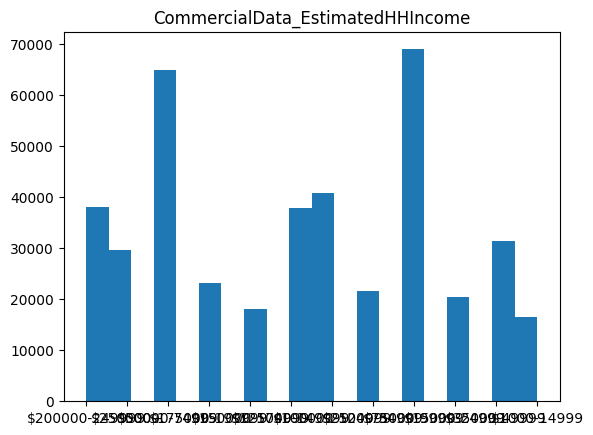

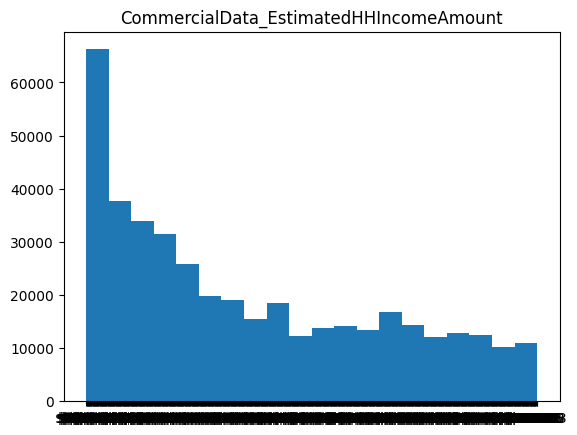

CommercialData_EstimatedHHIncome
$75000-99999      68902
$50000-74999      64918
$100000-124999    40857
$200000-249999    37997
$125000-149999    37896
$35000-49999      31325
$250000+          29608
$175000-199999    23236
$25000-34999      21653
$15000-24999      20413
$150000-174999    18156
$1000-14999       16546
Name: count, dtype: int64
CommercialData_EstimatedHHIncomeAmount
$250000    26488
$6000       2846
$276491     2681
$7000       2246
$146000     2072
           ...  
$192145        2
$159258        2
$210787        2
$28421         2
$14749         1
Name: count, Length: 844, dtype: int64
CommercialData_EstimatedAreaMedianHHIncome
$276491    4575
$59499     2441
$49749     2391
$221616    2321
$22675     2008
           ... 
$159258       3
$207008       2
$210787       2
$14749        1
$145832       1
Name: count, Length: 601, dtype: int64


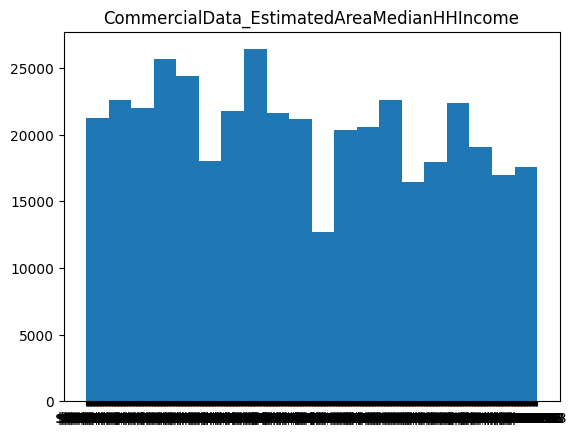

In [9]:

df_income = df[['CommercialData_EstimatedHHIncome', 'CommercialData_EstimatedHHIncomeAmount', 'CommercialData_EstimatedAreaMedianHHIncome']].dropna()

print(df_income.head())
# histogram of CommercialData_EstimatedHHIncome
plt.hist(df_income['CommercialData_EstimatedHHIncome'], bins=20)
plt.title('CommercialData_EstimatedHHIncome')
plt.show()

# histogram of CommercialData_EstimatedHHIncomeAmount
plt.hist(df_income['CommercialData_EstimatedHHIncomeAmount'], bins=20)
plt.title('CommercialData_EstimatedHHIncomeAmount')
plt.show()

# histogram of CommercialData_EstimatedAreaMedianHHIncome
plt.hist(df_income['CommercialData_EstimatedAreaMedianHHIncome'], bins=20)
plt.title('CommercialData_EstimatedAreaMedianHHIncome')

# first column is a range, 2nd is raw values
print(df_income['CommercialData_EstimatedHHIncome'].value_counts())
print(df_income['CommercialData_EstimatedHHIncomeAmount'].value_counts())
print(df_income['CommercialData_EstimatedAreaMedianHHIncome'].value_counts())

# CommercialData_EstHomeValue as well?


In [86]:
voter_df = pd.read_csv('boston_voter_data_cleaned.csv')
appeals_df = pd.read_csv('data/zoning-board-appeal.csv')

C:\Users\Andre\AppData\Local\Temp\ipykernel_17588\2655969148.py:1: DtypeWarning: Columns (45,46,49,53,57,59,61,62,75,94,97,98,99,104,107,118,121,126,132,136,143,144,147,148,179,180,181,182,183,184,185) have mixed types. Specify dtype option on import or set low_memory=False.
  voter_df = pd.read_csv('boston_voter_data_cleaned.csv')


In [87]:
# This cell is to gather the lat/long coordinates for each address in the appeals data

import re

appeals_df = appeals_df[['address', 'city', 'zip']]
address_cols = [col for col in voter_df.columns if 'addresses' in col.lower()]
appeals_df_og = appeals_df.copy()

#todo: modify appeals address col to strip everything after suffix, then append zip, not city
voter_df = voter_df[address_cols]
# print(appeals_df.head())
def format_address(address):
    # Expanded pattern to include various street suffixes
    pattern = r'(St|Ave|Blvd|Dr|Ct|Pl|Sq|Ln|Rd|Trl|Pkwy|Cmns|Ter|Cir|Aly|Way).*'
    return re.sub(pattern, r'\1', address)

def format_address_caps(address):
    # Pattern to match 'number to number'
    range_pattern = r'(\d+)\s+to\s+\d+'
    address = re.sub(range_pattern, r'\1', address)

    # Pattern with uppercase street suffixes
    suffix_pattern = r'(ST|AVE|BLVD|DR|CT|PL|SQ|LN|RD|TRL|PKWY|CMNS|TER|CIR|ALY|WAY|AV).*'
    return re.sub(suffix_pattern, r'\1', address)
# make all rows lowercase in str columns
appeals_df['address'] = appeals_df['address'].str.replace(' AV', ' AVE')
appeals_df['address'] = appeals_df['address'].str.replace(' St', ' ST')
appeals_df['address'] = appeals_df['address'].str.replace(' Sq', ' SQ')
appeals_df['address'] = appeals_df['address'].str.replace(' Av', ' AVE')
appeals_df['address'] = appeals_df['address'].apply(format_address_caps).str.lower()
appeals_df['address'] = appeals_df['address'] + ' ' + appeals_df['zip'].astype(str)

appeals_df['id'] = appeals_df.index

print(appeals_df['address'].head())
# remove street suffixes from voter data
voter_df['Residence_Addresses_AddressLine'] = voter_df['Residence_Addresses_AddressLine'].apply(format_address)
voter_df['address_merge'] = voter_df['Residence_Addresses_AddressLine'] + ' ' + (voter_df['Residence_Addresses_Zip'].astype(str))
voter_df['address_merge'] = voter_df['address_merge'].str.lower()
print(voter_df['address_merge'].head())
print(appeals_df['address'].head())

# remove duplicates in voter data
voter_df.drop_duplicates(subset=['address_merge'], inplace=True)

# merge on closest matching address
merged_df = appeals_df.merge(voter_df, left_on='address', right_on='address_merge', how='left')

print(len(appeals_df))
print(len(merged_df))


merged_df = merged_df[['address', 'city', 'zip', 'Residence_Addresses_Latitude', 'Residence_Addresses_Longitude', 'id']]

# get original address based on ID
merged_df['address'] = merged_df['id'].apply(lambda x: appeals_df_og.loc[x]['address'])
merged_df.to_csv('appeals_latlong.csv', index=False)




0           335 k st 2127
1           384 k st 2127
2      26 newburg st 2131
3    675 e fourth st 2127
4      960 centre st 2130
Name: address, dtype: object
0    209 commonwealth ave 2467
1       99-30 florence st 2467
2       99-30 florence st 2467
3       99-30 florence st 2467
4       99-30 florence st 2467
Name: address_merge, dtype: object
0           335 k st 2127
1           384 k st 2127
2      26 newburg st 2131
3    675 e fourth st 2127
4      960 centre st 2130
Name: address, dtype: object
9104
9104


In [88]:
len(merged_df[merged_df['Residence_Addresses_Latitude'].isna()])
#4505

4505